In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os                                                                                               
from src import data_io
import shelve
from contextlib import closing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cPickle as pickle

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score

from sklearn.decomposition import PCA, TruncatedSVD

from time import time

In [2]:
load = True
if load:
    bidders_d, auctions_d = data_io.load_bidders_auctions()
    
train_ids = [bidder_id for bidder_id, bidder in bidders_d.items() 
             if bidder.true_outcome != None]

train_bidders = [bidders_d[train_id] for train_id in train_ids]



In [3]:
bids_df = data_io.load_bids()

In [3]:
y = np.array([b.true_outcome for b in train_bidders])
k = 4
skf = StratifiedKFold(y, n_folds=k, random_state=0)

In [4]:
snipe_feats = pickle.load(open('../data/snipe_counts.p', 'rb'))
diversity_feats = pd.read_pickle('../data/df_diversity_feats.p').to_dict()['diversity_feat']
peak_feats = pd.read_pickle('../data/df_peak_feats.p').to_dict()['peak_feat']
peak_feats5e9 = pd.read_pickle('../data/df_peak5e9_feats.p').to_dict()['peak_feat']
peak_feats2e10 = pd.read_pickle('../data/df_peak2e10_feats.p').to_dict()['peak_feat']
peak_feats1e11 = pd.read_pickle('../data/df_peak1e11_feats.p').to_dict()['peak_feat']
count_feats = pd.read_pickle('../data/df_counts_feats.p').to_dict()['counts_feat']


fl_feats = pickle.load(open('../data/firstlast_feats.p', 'rb'))
consec_feats = pickle.load(open('../data/consec_feats.p', 'rb'))
wav_feats = pickle.load(open('../data/wav_feats.p', 'rb'))
dt_feats = pickle.load(open('../data/dt_feats.p', 'rb'))
pos_feats = pickle.load(open('../data/pos_feats.p', 'rb'))

In [5]:
import features
reload(features)
from features import *

tic = time()

X1 = [snipe_feats[b.bidder_id] for b in train_bidders]
X2 = BidsPerAuct().transform(train_bidders)
# X3 = BidDiversity(bids_df).transform(train_bidders)
X3 = [diversity_feats[b.bidder_id] for b in train_bidders]
X4 = [count_feats[b.bidder_id] for b in train_bidders]

X5_1 = [peak_feats[b.bidder_id] for b in train_bidders]
X5_2 = [peak_feats5e9[b.bidder_id] for b in train_bidders]
X5_3 = [peak_feats2e10[b.bidder_id] for b in train_bidders]
X5_4 = [peak_feats1e11[b.bidder_id] for b in train_bidders]

X6 = [fl_feats[b.bidder_id] for b in train_bidders]

X7 = [consec_feats[b.bidder_id] for b in train_bidders]
X8 = [wav_feats[b.bidder_id] for b in train_bidders]
X9 = [dt_feats[b.bidder_id] for b in train_bidders]
X10 = [pos_feats[b.bidder_id] for b in train_bidders]

keep_inds = pickle.load(open('../data/keep_inds.p', 'rb'))

# X = np.c_[X1, X2, X3]
# X = np.c_[X2, X3, X4]
X = np.c_[X2, X3, 
#           np.array(X4)[:, keep_inds],
          np.array(X4),
          X5_1, X5_2, X5_3, X5_4,
          X6, X7, X8, X9, X10]
# X = np.c_[X2, X3, X4, PCA(n_components=5).fit_transform(np.array(X5)[:, keep_inds])]

# X = np.c_[X1, X2, X3, X4, X5]

In [6]:
print X.shape

(2013, 7862)


In [7]:
np.save('../data/X_huge.npy', X)
np.save('../data/y_huge.npy', y)

In [8]:
## Test data

sub = pd.read_csv('../data/sampleSubmission.csv')
test_bidders = [bidders_d[test_id] for test_id in sub['bidder_id']]
len(test_bidders)

X1_test = [snipe_feats[b.bidder_id] for b in test_bidders]
X2_test = BidsPerAuct().transform(test_bidders)
X3_test = [diversity_feats[b.bidder_id] for b in test_bidders]

X4_test = [count_feats[b.bidder_id] for b in test_bidders]

X5_1_test = [peak_feats[b.bidder_id] for b in test_bidders]
X5_2_test = [peak_feats5e9[b.bidder_id] for b in test_bidders]
X5_3_test = [peak_feats2e10[b.bidder_id] for b in test_bidders]
X5_4_test = [peak_feats1e11[b.bidder_id] for b in test_bidders]

X6_test = [fl_feats[b.bidder_id] for b in test_bidders]
X7_test = [consec_feats[b.bidder_id] for b in test_bidders]
X8_test = [wav_feats[b.bidder_id] for b in test_bidders]
X9_test = [dt_feats[b.bidder_id] for b in test_bidders]
X10_test = [pos_feats[b.bidder_id] for b in test_bidders]

X_test = np.c_[X2_test, X3_test, 
#                np.array(X4_test)[:, keep_inds],
               np.array(X4_test),
               X5_1_test, X5_2_test, X5_3_test, X5_4_test,
               X6_test, X7_test, X8_test, X9_test, X10_test]

In [9]:
np.save('../data/X_huge_test.npy', X_test)

In [10]:
X_all = np.r_[X, X_test]
print X_all.shape

(6713, 7862)


# Visualization?

In [414]:
import bhtsne

tsne2 = bhtsne.bh_tsne(StandardScaler().fit_transform(
#         X_all
        np.r_[X10, X10_test]
    ), no_dims=2)

X_tsne2 = np.array([result for result in tsne2])

# tsne3 = bhtsne.bh_tsne(X_all, no_dims=3)
# X_tsne3 = np.array([result for result in tsne3])

In [415]:
# give y for test subjects
y_tsne = np.array([{0:'b', 1:'r', None:'gray'}[b.true_outcome] for b in bidders_d.values()])

In [116]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap, MDS, SpectralEmbedding

# X2 = MDS().fit_transform(X_all)
# X2 = LocallyLinearEmbedding(eigen_solver='dense').fit_transform(X_all)
# X2 = Isomap(n_neighbors=20).fit_transform(X_all)
X_spec = SpectralEmbedding().fit_transform(
#     X_all
    np.r_[X9, X9_test]
)

X_spec_train = X_spec[:len(X), :]

/afs/ee.cooper.edu/user/t/a/tam8/documents/scikit-learn/sklearn/neighbors/graph.py:36: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)


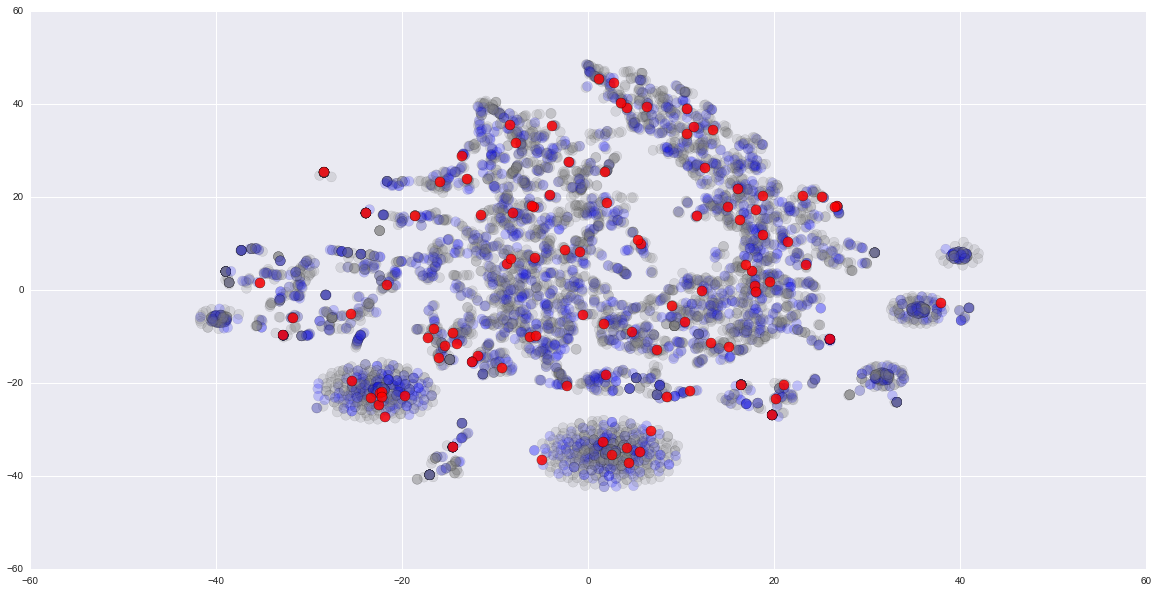

In [416]:
plt.figure(figsize=(20,10))
if 0:
    plt.scatter(X_spec[:,0], X_spec[:,1], c=y_tsne,
                lw=0.3, alpha=0.5,
                s=100)
    plt.scatter(X_spec[np.where(y_tsne=='r'),0], X_spec[np.where(y_tsne=='r'),1],
                c='r', alpha=1, s=100)
else:
    plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y_tsne,
                lw=0.3, alpha=0.2,
                s=100)
    plt.scatter(X_tsne2[np.where(y_tsne=='r'),0], X_tsne2[np.where(y_tsne=='r'),1],
                c='r', alpha=0.8, s=100)

In [289]:
# give y for test subjects
y_tsne = np.array([{0:'b', 1:'r', None:'gray'}[b.true_outcome] for b in bidders_d.values()])

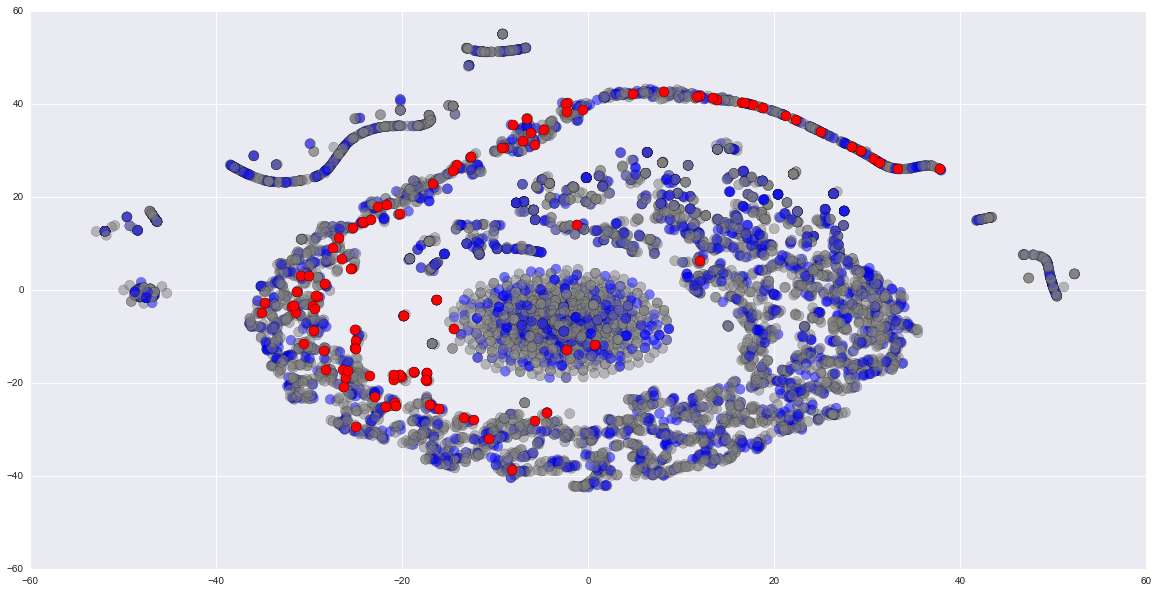

In [290]:
plt.figure(figsize=(20,10))
# ec = {0: 'black', 1: 'r'}
# plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y,
#             lw=1, alpha=1, 
#             cmap='Reds', edgecolor=[ec[y_i] for y_i in y],
#             s=100)

# ec = {0: 'black', 1: 'r'}
# plt.scatter(X_tsne2[np.where(y),0], X_tsne2[np.where(y),1],
#             lw=1, alpha=1, 
#             cmap='Reds', edgecolor=[ec[y_i] for y_i in y],
#             s=100)

plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y_tsne,
            lw=0.3, alpha=0.5,
            s=100)
plt.scatter(X_tsne2[np.where(y_tsne=='r'),0], X_tsne2[np.where(y_tsne=='r'),1],
            c='r', alpha=1, s=100)

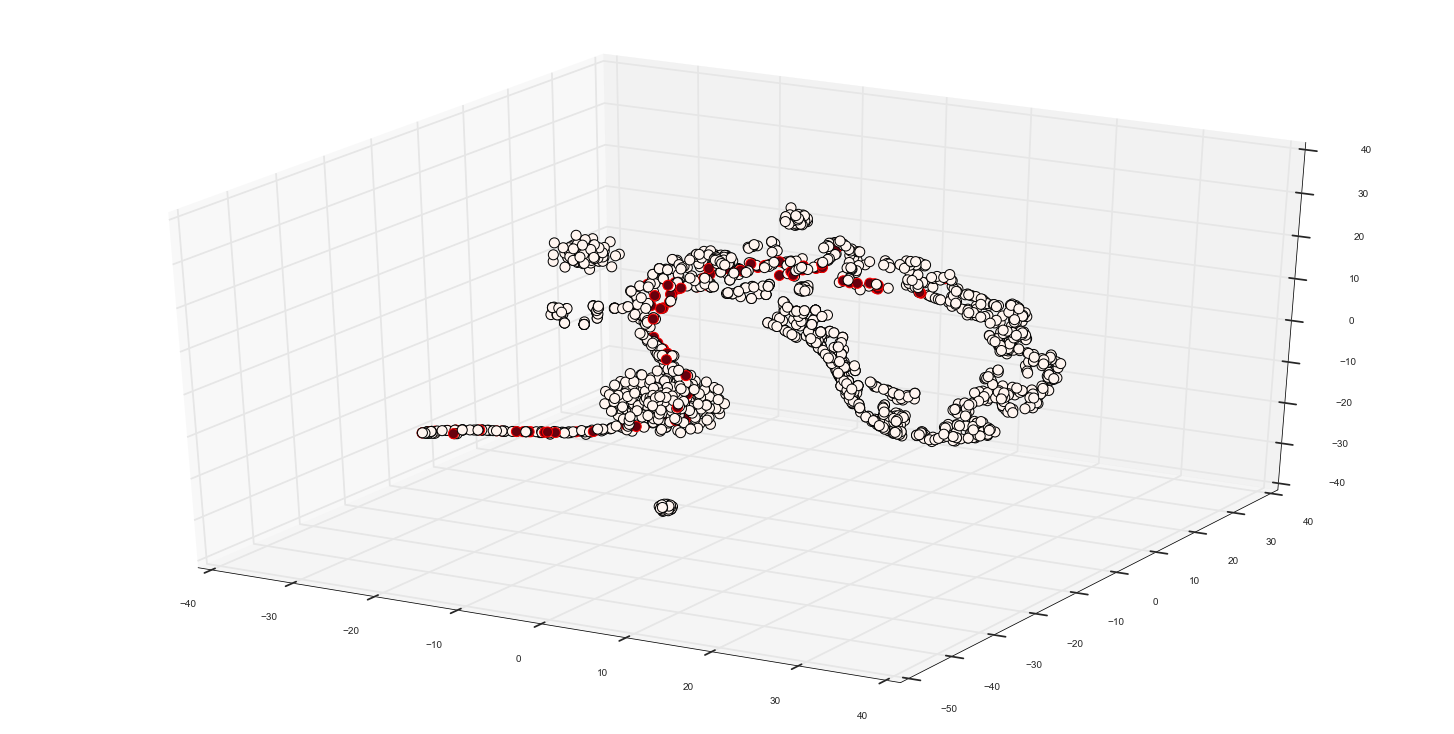

In [322]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
ax.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=y,
            lw=1, alpha=1, 
            cmap='Reds', edgecolor=[ec[y_i] for y_i in y],
            s=100)

In [324]:
# Adding tsne reduction to feats
X = np.c_[X, X_tsne3]

# Some sklearn models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, make_union, Pipeline


# clf = LogisticRegression()
# clf = make_pipeline(StandardScaler(), SVC(probability=True))
# clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.15)

# clf = BaggingClassifier(n_estimators=500,
#                         bootstrap_features=True,
#                         max_samples=0.8,
#                         max_features=0.6,
#                         n_jobs=-1)

# clf = ExtraTreesClassifier(bootstrap=False, 
#                            min_samples_leaf=3,
#                            n_estimators=500,
#                            min_samples_split=5,
#                            criterion='entropy',
#                            max_features=40,
#                            max_depth=None,
#                            n_jobs=-1,
#                           )

# clf = ExtraTreesClassifier(bootstrap=False, 
#                            min_samples_leaf=2,
#                            n_estimators=400,
#                            min_samples_split=5,
#                            criterion='gini',
#                            max_features=63,
#                            max_depth=None,
#                            n_jobs=-1,
#                           )

## large feats
clf = ExtraTreesClassifier(bootstrap=False, 
                           min_samples_leaf=2,
                           n_estimators=400,
                           min_samples_split=5,
                           criterion='gini',
                           max_features=80,
                           max_depth=None,
                           n_jobs=-1,
                          )

# # for boxcox _ id feats
# clf = ExtraTreesClassifier(bootstrap=False, 
#                            min_samples_leaf=8,
#                            n_estimators=200,
#                            min_samples_split=7,
#                            criterion='entropy',
#                            max_features=30,
#                            max_depth=None,
#                            n_jobs=-1,
#                           )

# et = ExtraTreeClassifier(min_samples_leaf=2,
#                          min_samples_split=5,
#                          criterion='gini',
#                          max_features=63,
#                          max_depth=None,)
# clf = AdaBoostClassifier(base_estimator=et, 
#                          n_estimators=400, 
#                          learning_rate=0.15)

# clf = make_pipeline(StandardScaler(),
#     KNeighborsClassifier(n_neighbors=100, weights='distance', metric='minkowski'))

# clf = GradientBoostingClassifier(n_estimators=1000)



In [9]:
## TRYING OUT RFE
X4 = [count_feats[b.bidder_id] for b in train_bidders]
clf.fit(X4, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=32, max_leaf_nodes=None,
           min_samples_leaf=3, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=380, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

(0, 0.015)

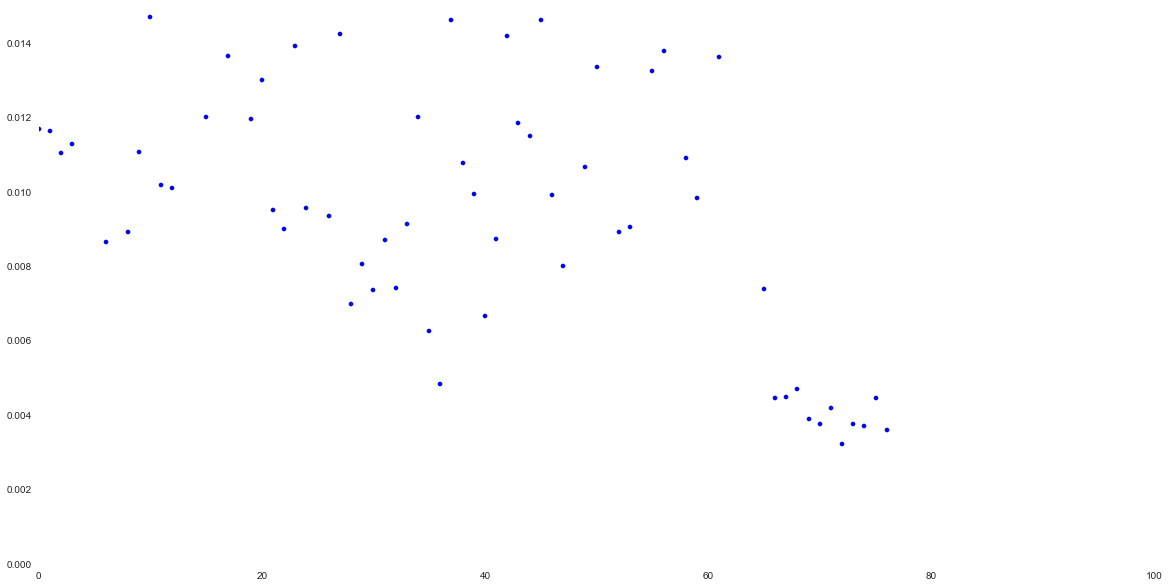

In [120]:
pipe.fit(X,y)
plt.figure(figsize=(20,10))
fi = pipe.steps[1][1].feature_importances_
plt.scatter(range(len(fi)), fi, lw=0.1)
plt.xlim([0, 100])
plt.ylim([0, 0.015])

In [14]:
top_n = 10

keep_inds = (-fi).argsort()[:top_n]
keep_inds.shape
pickle.dump(keep_inds, open('../data/keep_inds.p', 'wb'))

In [12]:
import src.transformers
reload(src.transformers)
from src.transformers import *
from sklearn.preprocessing import MinMaxScaler

pipe = make_pipeline(make_union(
        IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ), 
#                      StandardScaler(),
                     clf,
                    )

In [13]:
from itertools import chain
scores_rep = []
for ii in range(5):
    skf = StratifiedKFold(y, n_folds=k, random_state=np.random.randint(0,100))
    print ii,
    scores = cross_val_score(
        estimator=pipe, 
        X=X,
        y=y, 
        scoring='roc_auc',
        cv=skf, 
        n_jobs=1)
    scores_rep.append(scores)
scores_all = np.array(list(chain(*scores_rep)))

0 1 2 3 4


In [14]:
print scores_all
print scores_all.mean()
print scores_all.std()


[ 0.93619247  0.89523656  0.90348331  0.92813417  0.93426135  0.89958159
  0.90630543  0.92939203  0.93442227  0.89483425  0.90719239  0.93115304
  0.93498552  0.89660444  0.9087244   0.93140461  0.93941101  0.89386868
  0.90759555  0.93148847]
0.917213577038
0.0165219676687


- 0.90901903543  nothing
- 0.909414208061 log
- 0.909018445702 tukey
- 0.909177150196 InverseTformer
- 0.909571835154 GLogTformer(1)
- 0.913309346616 make_pipeline(AddTformer(1), BoxCoxTformer())

(-0.0001, 0.01)

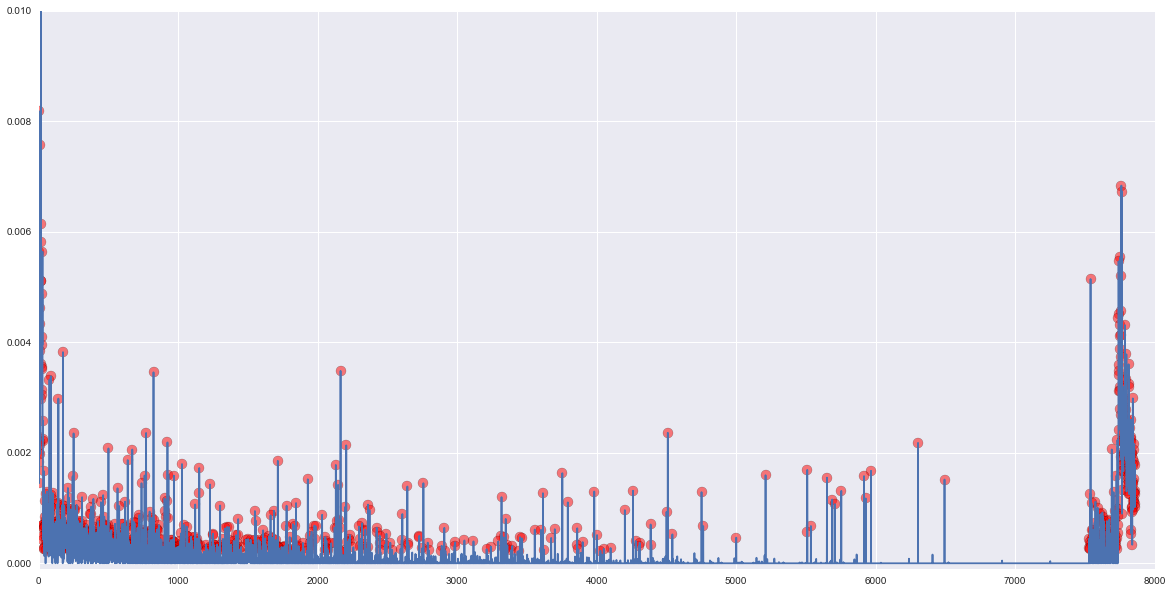

In [15]:
plt.figure(figsize=(20,10))
clf.fit(X,y)
fi = clf.feature_importances_
plt.plot(fi)
top_n = 1000
important_inds = (-fi).argsort()[:top_n]
plt.scatter(important_inds, fi[important_inds], alpha=0.5, s=100, c='r')
plt.xlim([-1, 8000])
plt.ylim([-0.0001, 0.010])

In [48]:
print important_inds.shape
pickle.dump(important_inds, open('../data/important_inds.npy', 'wb'))

(1000,)


In [121]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {
    "n_estimators": sp_randint(10, 800),
    "max_depth": [3, 5, 10, 50, None],
    "max_features": sp_randint(1, X.shape[1]),
    "min_samples_split": sp_randint(1, 15),
    "min_samples_leaf": sp_randint(1, 15),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]}


n_iter_search = 500
random_search = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(), 
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=n_iter_search,
    n_jobs=-1)

tic = time()
random_search.fit(X, y)
toc = time() - tic
print toc

592.964884043


In [121]:
from scipy.stats import randint as sp_randint
param_dist = {
    "n_estimators": sp_randint(5, 500),
    "learning_rate": np.arange(0.1,1.5,0.05),}


n_iter_search = 500
random_search = RandomizedSearchCV(
    estimator=AdaBoostClassifier(), 
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=n_iter_search,
    n_jobs=-1)

tic = time()
random_search.fit(X, y)
toc = time() - tic
print toc

486.280086994


In [99]:
# PIPE

from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

pipe = Pipeline([('feats', make_union(
        IdentityTformer(), make_pipeline(AddTformer(1), BoxCoxTformer()),
    )), 
#                  ('etc', ExtraTreesClassifier()),
#                  ('ada', AdaBoostClassifier()),
                 ('bc', AdaBoostClassifier()),
                ])


# param_dist = {
#     "etc__n_estimators": sp_randint(10, 500),
#     "etc__max_depth": [3, None],
#     "etc__max_features": sp_randint(1, X.shape[1]),
#     "etc__min_samples_split": sp_randint(1, 15),
#     "etc__min_samples_leaf": sp_randint(1, 15),
#     "etc__bootstrap": [True, False],
#     "etc__criterion": ["gini", "entropy"]}

# param_dist = {
#     "ada__n_estimators": sp_randint(5, 500),
#     "ada__learning_rate": np.arange(0.1,1.5,0.05),}

param_dist = {
    "bc__n_estimators": 500,
    "bc__bootstrap_features": [False, Truebc__],
    "bc__max_samples": 1.0,
    "bc__max_features": 0.9,
}


n_iter_search = 100
random_search = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=n_iter_search,
    n_jobs=-1)

tic = time()
random_search.fit(X, y)
toc = time() - tic
print toc

196.201013088


In [122]:
print random_search.best_score_
print random_search.best_params_

0.931170217322
{'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 362, 'min_samples_split': 5, 'criterion': 'gini', 'max_features': 63, 'max_depth': None}


#Trying XGBoost

In [277]:
X.shape

(2013, 7841)

In [22]:
import xgboost as xgb

# Parameters for XGB
params = {
    'num_class': 2,
    'silent': 0,    # 0 is verbose
    'nthread': 7,    # max if not set
    
    'bst:eta': 1.0,
    'bst:gamma': 1.0,
    'bst:max_depth': 3,
    'bst:min_child_weight': 1,
    'bst:max_delta_step': 0,
    'bst:subsample': .5,    # Row (observation) subsample
    'bst:colsample_bytree': 0.8,    # Col (feature) subsample
    
    'objective':'binary:logitraw',
    'eval_metric': 'auc',
    
    'seed': 0,
}

dtrain = xgb.DMatrix(X, label=y)


In [285]:
num_round = 100
scores_xgb = xgb.cv(params, dtrain, num_round, nfold=4,
                    metrics={'auc'}, seed = 0)

[0]	cv-test-auc:0.510870+0.061922	cv-train-auc:0.528639+0.023931
[1]	cv-test-auc:0.523383+0.027405	cv-train-auc:0.619819+0.031569
[2]	cv-test-auc:0.529086+0.049924	cv-train-auc:0.688668+0.024208
[3]	cv-test-auc:0.512329+0.053515	cv-train-auc:0.754915+0.024901
[4]	cv-test-auc:0.522227+0.063220	cv-train-auc:0.784530+0.018115
[5]	cv-test-auc:0.511242+0.032581	cv-train-auc:0.800062+0.014277
[6]	cv-test-auc:0.512187+0.042006	cv-train-auc:0.828534+0.015239
[7]	cv-test-auc:0.510746+0.042405	cv-train-auc:0.851095+0.009184
[8]	cv-test-auc:0.514428+0.047454	cv-train-auc:0.862472+0.008175
[9]	cv-test-auc:0.496206+0.049495	cv-train-auc:0.862678+0.008021
[10]	cv-test-auc:0.505913+0.040584	cv-train-auc:0.877502+0.009760
[11]	cv-test-auc:0.501360+0.051049	cv-train-auc:0.886878+0.016327
[12]	cv-test-auc:0.503222+0.050001	cv-train-auc:0.889986+0.015264
[13]	cv-test-auc:0.498347+0.042554	cv-train-auc:0.904513+0.011800
[14]	cv-test-auc:0.516478+0.049581	cv-train-auc:0.915739+0.010518
[15]	cv-test-auc:0.5

In [433]:
scores_gbm = []
for reps in range(5):
    skf = StratifiedKFold(y, n_folds=k,
                          shuffle=True,
                          random_state=np.random.randint(0,100))
    for ii, (train, valid) in enumerate(skf):
        history = LossHistory()
        print 'Fold %d' % ii,
        X_train = X[train]
        X_valid = X[valid]
        y_train = y[train]
        y_valid = y[valid]


        gbm = xgb.XGBClassifier(
#             objective="binary:logitraw",
            objective="binary:logistic",
            n_estimators=50,
            learning_rate=0.1,
            gamma=0.0,
            max_depth=100,
            min_child_weight=10,
            max_delta_step=10,
            subsample=0.85,
            colsample_bytree=0.8,
            base_score=0.5,
            nthread=7,
            seed=np.random.randint(0,100),
            silent=True,
        )
        tic = time()
        gbm.fit(X_train, y_train)
        toc = time() - tic
        print 'Train time: %2.3f s\t' % toc, 

        valid_preds = gbm.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, valid_preds)
        print 'ROC %1.5f' % roc
        scores_gbm.append(roc)
print "done"
print np.array(scores_gbm).mean()

Fold 0 Train time: 0.372 s	ROC 0.92992
Fold 1 Train time: 0.334 s	ROC 0.94794
Fold 2 Train time: 0.335 s	ROC 0.88792
Fold 3 Train time: 0.336 s	ROC 0.94721
Fold 0 Train time: 0.339 s	ROC 0.92078
Fold 1 Train time: 0.341 s	ROC 0.94730
Fold 2 Train time: 0.396 s	ROC 0.93876
Fold 3 Train time: 0.352 s	ROC 0.93564
Fold 0 Train time: 0.345 s	ROC 0.95027
Fold 1 Train time: 0.322 s	ROC 0.94750
Fold 2 Train time: 0.325 s	ROC 0.92876
Fold 3 Train time: 0.346 s	ROC 0.95132
Fold 0 Train time: 0.326 s	ROC 0.93961
Fold 1 Train time: 0.342 s	ROC 0.95108
Fold 2 Train time: 0.330 s	ROC 0.91167
Fold 3 Train time: 0.333 s	ROC 0.95459
Fold 0 Train time: 0.323 s	ROC 0.91865
Fold 1 Train time: 0.336 s	ROC 0.96194
Fold 2 Train time: 0.321 s	ROC 0.93316
Fold 3 Train time: 0.328 s	ROC 0.94340
done
0.937370787982


0.918403716771


#Testing Keras

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adadelta, RMSprop, Adagrad
from keras.regularizers import l1, l2, l1l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback
y_enc = np_utils.to_categorical(y)


Using gpu device 0: GeForce GTX 580


In [18]:
prepipe = make_pipeline(
    make_union(
        IdentityTformer(),
#         AnscombeTformer(),
        make_pipeline(AbsTformer(), AddTformer(1), BoxCoxTformer()),
    ), StandardScaler(),
)

X_post = prepipe.fit_transform(X[:, important_inds])

In [19]:
print X_post.shape
dims = X_post.shape[1]
nb_classes = y_enc.shape[1]

(2013, 2000)


In [20]:

def build_model_old(input_dim, output_dim):
    model = Sequential()
    model.add(Dropout(0.5))
    model.add(Dense(input_dim, 256, init='he_uniform', W_regularizer=l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
    model.add(PReLU(256))
    model.add(Dropout(0.5))

    model.add(Dense(256, 256, init='he_uniform', W_regularizer=l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
    model.add(PReLU(256))
    model.add(Dropout(0.5))

    model.add(Dense(256, 256, init='he_uniform', W_regularizer=l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
    model.add(PReLU(256))
    model.add(Dropout(0.5))

    model.add(Dense(256, 256, init='he_uniform', W_regularizer=l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
    model.add(PReLU(256))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, output_dim, init='he_uniform', W_regularizer = l1l2(l1=5e-5, l2=1e-5)))
    model.add(Activation('softmax'))

    adadelta = Adadelta(lr=1.0, rho=0.90, epsilon=1e-6)
#     model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    model.compile(loss='categorical_crossentropy', optimizer=adadelta)
    return model

def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dropout(0.8))
    model.add(Dense(input_dim, 1024, init='he_uniform', W_regularizer=l1l2(l1=1e-5, l2=1e-6)))
#     model.add(Activation('relu'))
    model.add(PReLU(1024))
    model.add(Dropout(0.5))

    model.add(Dense(1024, 512, init='he_uniform', W_regularizer=l1l2(l1=1e-5, l2=1e-6)))
#     model.add(Activation('relu'))
    model.add(PReLU(512))
    model.add(Dropout(0.5))

    model.add(Dense(512, 256, init='he_uniform', W_regularizer=l1l2(l1=1e-5, l2=1e-6)))
#     model.add(Activation('relu'))
    model.add(PReLU(256))
    model.add(Dropout(0.5))

    model.add(Dense(256, 256, init='he_uniform', W_regularizer=l1l2(l1=1e-5, l2=1e-6)))
#     model.add(Activation('relu'))
    model.add(PReLU(256))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, output_dim, init='he_uniform', W_regularizer = l1l2(l1=1e-5, l2=1e-6)))
    model.add(Activation('softmax'))

    adadelta = Adadelta(lr=.2, rho=0.90, epsilon=1e-6)
#     rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
    rmsprop = RMSprop(lr=0.0002, rho=0.9, epsilon=1e-6)
    adagrad = Adagrad(lr=0.01, epsilon=1e-6)
    
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
    return model

# def build_model(input_dim, output_dim):
#     model = Sequential()
#     model.add(Dropout(0.4))
#     model.add(Dense(input_dim, 256, init='he_uniform', W_regularizer = l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(256, 256, init='he_uniform', W_regularizer = l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(256, 256, init='he_uniform', W_regularizer = l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(256, output_dim, init='he_uniform', W_regularizer = l1l2(l1=5e-5, l2=1e-5)))
#     model.add(Activation('softmax'))

#     adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
#     model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
#     return model

In [27]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
history = LossHistory()

In [490]:
scores_keras = []
losses_list = []
k = 4
skf = StratifiedKFold(y, n_folds=k, random_state=np.random.randint(0,100))
for ii, (train, valid) in enumerate(skf):
    history = LossHistory()
#     print('---'*20)
    print 'Fold %d' % ii,
#     print('---'*20)
    X_train = X_post[train]
    X_valid = X_post[valid]
    Y_train = y_enc[train]
    Y_valid = y_enc[valid]
    y_valid = y[valid]
    
    print "Building model..",
    dims = X_train.shape[1]
    nb_classes = y_enc.shape[1]
    model = build_model(dims, nb_classes)

    print "Training model..",

    losses_list.append(model.fit(X_train, Y_train, nb_epoch=1000, batch_size=2048,
                                 callbacks=[history],
                                 validation_data=(X_valid, Y_valid), verbose=0))
    valid_preds = model.predict_proba(X_valid, verbose=0)
    valid_preds = valid_preds[:, 1]
    roc = roc_auc_score(y_valid, valid_preds)
    print "ROC: %1.5f" % roc
    scores_keras.append(roc)
    
#     break

Fold 0 Building model.. Training model.. ROC: 0.90135
Fold 1 Building model.. Training model.. ROC: 0.92171
Fold 2 Building model.. Training model.. ROC: 0.90308
Fold 3 Building model.. Training model.. ROC: 0.92998


In [453]:
losses_list[0].losses

[0.68172556161880493,
 0.66882121562957764,
 0.65302777290344238,
 0.63352400064468384,
 0.60960584878921509,
 0.58077377080917358,
 0.54637223482131958,
 0.50653845071792603,
 0.46260201930999756,
 0.41731506586074829,
 0.37441626191139221,
 0.33754914999008179,
 0.30732467770576477,
 0.28400173783302307,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 n

In [150]:
q = np.min(losses_list)
qq = np.min(losses_list)

(0.1, 0.16)

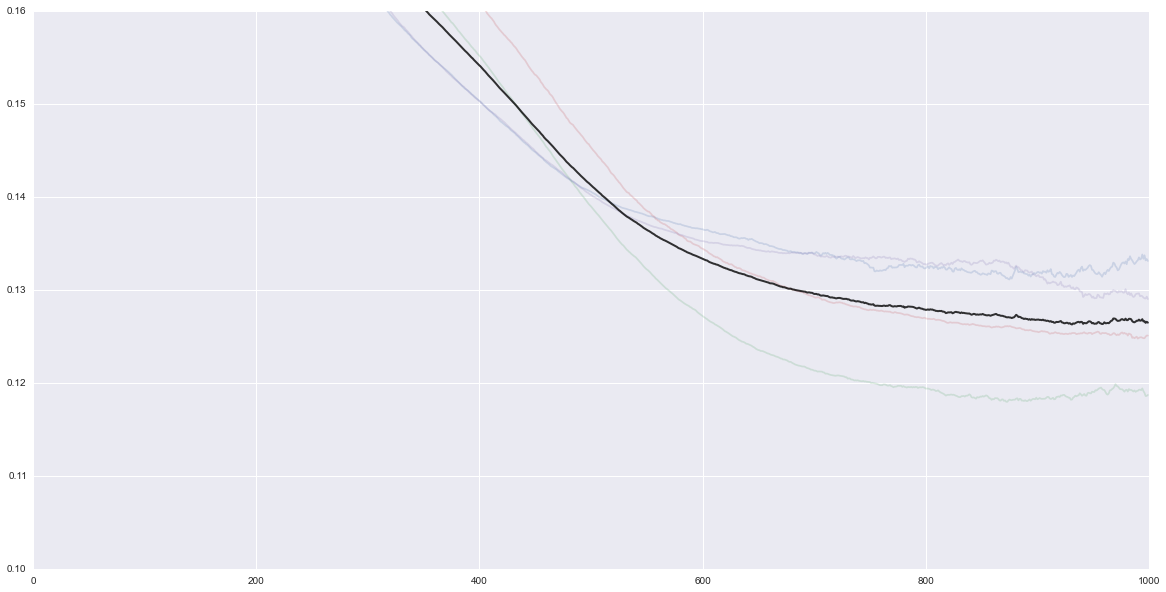

In [491]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
for score in losses_list:
#     plt.plot(score['val_loss'])
    plt.plot(score.losses, alpha=0.2)
plt.plot(np.array([ll.losses for ll in losses_list]).mean(axis=0), lw=2, c='black', alpha=0.8)

plt.ylim([0.1, 0.16])
# plt.plot([0, len(score['val_loss'])], [q, q])
# plt.plot([0, len(score['val_loss'])], [qq, qq])

In [484]:
np.mean(scores_keras)

0.90458740626933565

In [ ]:
# valid_preds
valid_preds[np.where(y_valid)]

# Prediction

## Ok, train first

In [97]:
X = np.load('../data/X.npy')[:, important_inds]
y = np.load('../data/y.npy')
X_test = np.load('../data/X_test.npy')[:, important_inds]

In [29]:
type (clf_keras)

keras.models.Sequential

In [40]:

clf_et = ExtraTreesClassifier(bootstrap=False, 
                           min_samples_leaf=2,
                           n_estimators=400,
                           min_samples_split=5,
                           criterion='gini',
                           max_features=80,
                           max_depth=None,
                           n_jobs=-1,
                          )
clf_adab = AdaBoostClassifier(n_estimators=50, learning_rate=0.15)
clf_bc = BaggingClassifier(n_estimators=500,
                        bootstrap_features=True,
                        max_samples=0.8,
                        max_features=0.6,
                        n_jobs=-1)

gbm = xgb.XGBClassifier(
#     objective="binary:logitraw",
    objective="binary:logistic",
    n_estimators=50,
    learning_rate=0.1,
    gamma=0.0,
    max_depth=100,
    min_child_weight=10,
    max_delta_step=10,
    subsample=0.85,
    colsample_bytree=0.8,
    base_score=0.5,
    nthread=7,
    seed=np.random.randint(0,100),
    silent=True,
)

# pipe_adab = make_pipeline(make_union(
#         IdentityTformer(), make_pipeline(AddTformer(1), BoxCoxTformer()),
#     ), clf_adab)

fuckingshit = make_pipeline(make_union(
        IdentityTformer(), 
        make_pipeline(AbsTformer(), AddTformer(1), BoxCoxTformer()),
    ), StandardScaler(),)

# clf_keras = KerasClassifier(build_model(dims, nb_classes))
dims = fuckingshit.fit_transform(X[:, important_inds]).shape[1]
clf_keras = build_model(dims, nb_classes)

# clf_keras = make_pipeline(make_union(
#         IdentityTformer(), make_pipeline(AddTformer(1), BoxCoxTformer()),
#     ), StandardScaler(), KerasClassifier(build_model(dims, nb_classes)))

# pipes = [pipe_et, pipe_adab]
# pipes = [clf_et, clf_bc, clf_keras]
# pipes = [clf_et, clf_bc, clf_keras]
# pipes = [clf_keras]
# pipes = [clf_keras, gbm, clf_et]
pipes = [gbm]

for pipe in pipes:
    print 'Fitting:', pipe
    if type(pipe) is KerasClassifier or type(pipe) is Sequential:
        pipe.fit(X=fuckingshit.fit_transform(X[:, important_inds]), 
                 y=np_utils.to_categorical(y), 
                 nb_epoch=1000, batch_size=2048, verbose=0,
                 callbacks=[history])
    else:
        pipe.fit(X, y)
# clf_bc.fit(X, y)


Fitting: XGBClassifier(base_score=0.5, colsample_bytree=0.8, gamma=0.0,
       learning_rate=0.1, max_delta_step=10, max_depth=100,
       min_child_weight=10, n_estimators=50, nthread=7,
       objective='binary:logistic', seed=63, silent=True, subsample=0.85)


## Setup test obs

In [41]:
sub = pd.read_csv('../data/sampleSubmission.csv')
test_bidders = [bidders_d[test_id] for test_id in sub['bidder_id']]
len(test_bidders)

4700

In [401]:
fuckingshit.fit_transform(X_test).shape

KeyboardInterrupt: 

In [42]:
y_pred_list = []
for pipe in pipes:
    if type(pipe) is KerasClassifier or type(pipe) is Sequential:
        y_pred_list.append(pipe.predict_proba(fuckingshit.fit_transform(X_test[:, important_inds]))[:, 1])
    else:
        y_pred_list.append(pipe.predict_proba(X_test)[:, 1])
    

# y_pred_1 = pipe1.predict_proba(X_test)[:, 1]
# y_pred_2 = pipe2.predict_proba(X_test)[:, 1]
# y_pred_bc = clf_bc.predict_proba(X_test)[:, 1]

# y_pred_avg = np.array([y_pred_et, y_pred_adab, y_pred_bc]).mean(axis=0)
y_pred_avg = np.array(y_pred_list).mean(axis=0)

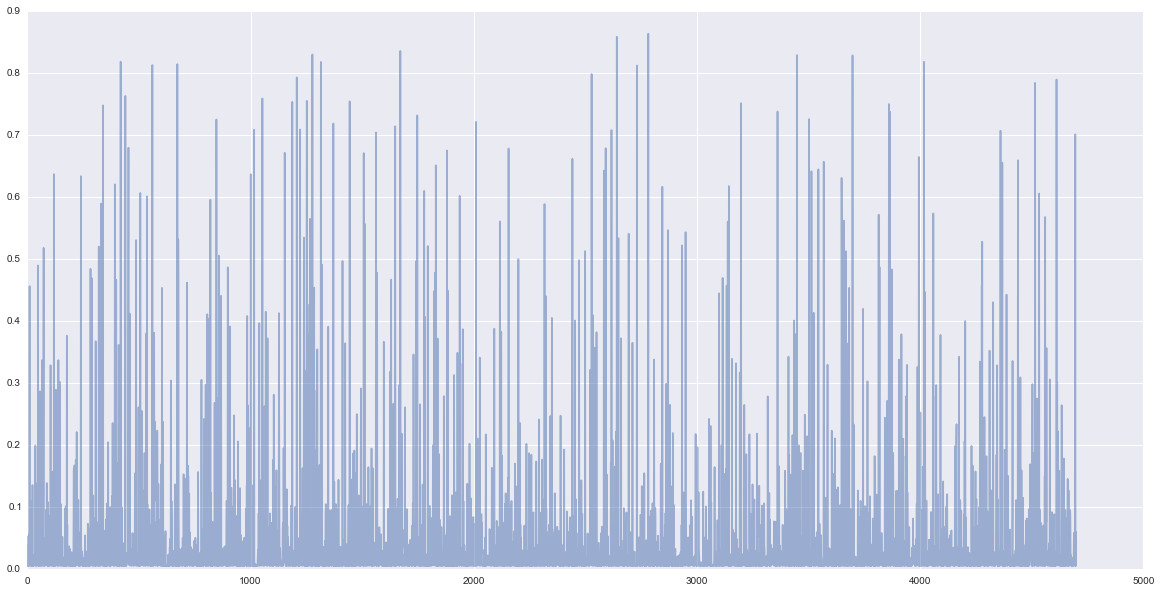

In [43]:
plt.figure(figsize=(20,10))
# plt.plot(np.array([y_pred_et, y_pred_adab, y_pred_bc]).T)
plt.plot(np.array(y_pred_list).T, alpha=0.5)

In [44]:
(y_pred_avg>0.6).sum()

65

In [45]:
sub['prediction'] = y_pred_avg

In [46]:
sub.to_csv('../submissions/xgb_addedposfeats.csv', index=False)

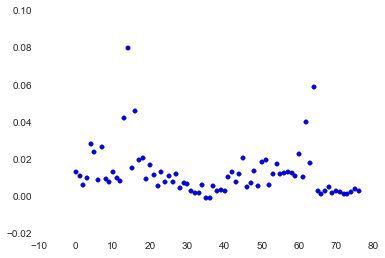

In [137]:
plt.scatter(range(len(clf_et.feature_importances_)), clf_et.feature_importances_)

(array([ 4123.,   256.,    86.,    62.,    48.,    36.,    27.,    24.,
           22.,    16.]),
 array([ 0.00444576,  0.09030888,  0.176172  ,  0.26203511,  0.34789823,
         0.43376134,  0.51962446,  0.60548758,  0.69135069,  0.77721381,
         0.86307693]),
 <a list of 10 Patch objects>)

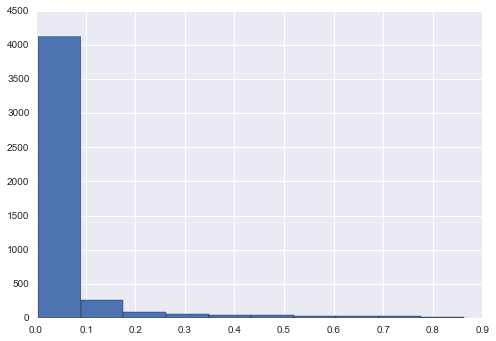

In [47]:
plt.hist(y_pred_avg)